# Using Traditional Image Recognition to Determine the Health of a Coral Colony

This project aims to assess the health of a coral colony by comparing its current condition to past data. The following visual indicators are used to mark different conditions:

- **Areas of Growth**: Marked with a green rectangle around the affected area.

- **Areas of Damage or Death**: Marked with a yellow rectangle around the affected area.

- **Areas of Bleaching/Blotching**: Marked with a red rectangle around the affected area.

- **Areas that Have Recovered from Bleaching/Blotching**: Marked with a blue rectangle around the affected area.

<img src="Example.png" alt="Example" width="700" />

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Global Variables for Adjusting Code Behavior

- **`showPoint = False`**  
  Enables point alignment between images, assisting in overlaying the two photos during resizing.

- **`draw = False`**  
  Activates drawing mode for visual representation.

- **`load_HSV_lower_upper = True`**  
  Loads the HSV bounds (lower and upper arrays) for color filtering.

- **`seeToEdit = False`**  
  Displays intermediate figures for editing purposes.

- **`Shift = 60`**  
  Specifies a pixel shift in the y direction to enhance accuracy.

- **`Flip = 0`**  
  Indicates whether the image requires an initial flip.

In [2]:
showPoint = False
draw = False     
load_HSV_lower_upper = True
seeToEdit = True   
Shift = 60  
Flip =0            

### Intialize
i = 0  # Counter to track the number of times the HSV function has been called. 
lowerA =np.array([])
upperA =np.array([])
def nothing(x):  ## For trackBar
    pass

# Helpful Functions

## 1 - Filter Functions

The following functions apply various morphological operations on images to refine their appearance and highlight specific features:

- **`errosion(img)`**  
  Applies erosion to an image, which can help remove small white noises and detach two connected objects in the image.

- **`dilation(img, dilatation_size)`**  
  Expands the white regions in an image to connect disjointed parts or enhance object boundaries.
- **`morph(img)`**  
  Performs a morphological opening operation, which is useful for removing small objects from the foreground, such as noise.

In [3]:
def errosion(img):
    """Applies erosion to the given image."""
    src_img = img.copy()
    dilatation_size = 2
    dilation_shape = cv2.MORPH_RECT
    element = cv2.getStructuringElement(dilation_shape, (2 * dilatation_size + 1, 2 * dilatation_size + 1),
                                        (dilatation_size, dilatation_size))
    eroded_image = cv2.erode(src_img, element)
    return eroded_image           

def dilation(img, dilatation_size):
    """Applies dilation to the given image."""
    src_img = img.copy()
    dilation_shape = cv2.MORPH_RECT
    element = cv2.getStructuringElement(dilation_shape, (2 * dilatation_size + 1, 2 * dilatation_size + 1),
                                        (dilatation_size, dilatation_size))
    dilated_image = cv2.dilate(src_img, element)
    return dilated_image

def morph(img):
    """Applies morphological opening operation to the given image."""
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return opening

## 2 - Get Color in Image

Each image varies due to factors such as:

1. Camera angle
2. Light intensity
3. Natural or synthetic lighting

This function helps set the lower and upper HSV (Hue, Saturation, Value) 
 bounds manually using trackbars, allowing for precise control of color range adjustments.

In [4]:
def HSV(img, waitTime=30):
    """Adjusts HSV color range using trackbars and applies the mask to the image."""
    global i ,lowerA,upperA
    if i < 1:
        cv2.namedWindow('Trackbar')
        cv2.resizeWindow('Trackbar', 700, 250)  # Set the desired width and height
        cv2.createTrackbar('HMin', 'Trackbar', 0, 179, nothing)
        cv2.createTrackbar('SMin', 'Trackbar', 0, 255, nothing)
        cv2.createTrackbar('VMin', 'Trackbar', 0, 255, nothing)
        cv2.createTrackbar('HMax', 'Trackbar', 0, 179, nothing)
        cv2.createTrackbar('SMax', 'Trackbar', 0, 255, nothing)
        cv2.createTrackbar('VMax', 'Trackbar', 0, 255, nothing)

        cv2.setTrackbarPos('HMax', 'Trackbar', 179)
        cv2.setTrackbarPos('SMax', 'Trackbar', 255)
        cv2.setTrackbarPos('VMax', 'Trackbar', 255)

        img = cv2.resize(img, (640, 480))

        while True:
            # Get trackbar positions for HSV values
            hMin = cv2.getTrackbarPos('HMin', 'Trackbar')
            sMin = cv2.getTrackbarPos('SMin', 'Trackbar')
            vMin = cv2.getTrackbarPos('VMin', 'Trackbar')
            hMax = cv2.getTrackbarPos('HMax', 'Trackbar')
            sMax = cv2.getTrackbarPos('SMax', 'Trackbar')
            vMax = cv2.getTrackbarPos('VMax', 'Trackbar')

            # Set HSV bounds
            lower = np.array([hMin, sMin, vMin], dtype="uint8")
            upper = np.array([hMax, sMax, vMax], dtype="uint8")

            lowerA = lower
            upperA = upper

            # Create HSV mask
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv, lower, upper)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            output = cv2.bitwise_and(img, img, mask=mask)

            # Display output
            cv2.imshow('Filtered Image', output)
            cv2.imshow('Original Image', img)
            if cv2.waitKey(waitTime) & 0xFF == 27:
                break
        cv2.destroyAllWindows()
    else:
        print(lowerA)
        lower = lowerA
        upper = upperA
    i += 1  # how many times we call this functions.
    return lower, upper # Lower and upper HSV bounds as numpy arrays.

## 3 - Find Contour with the Maximum Area.

The `findArea` function is designed to identify the contour with the maximum area within a given image. It processes the image by converting it to the HSV color space and applying a mask to isolate the desired contours. This function is essential for tasks that require identifying the largest object in an image based on its area.

In [5]:
def findArea(image_):
    """Finds the contour with the maximum area in the image."""
    original = image_.copy()    
    
    # Convert the image from BGR to HSV color space
    image = cv2.cvtColor(image_, cv2.COLOR_BGR2HSV)
    # Obtain the lower and upper bounds for the desired color range
    if(load_HSV_lower_upper):
        loaded = np.load("HSV.npz")
        lowerArray, upperArray =  loaded['lowerA'] , loaded['upperA']
    else:
        lowerArray, upperArray = HSV(image_.copy())
    # Convert the lower and upper bounds to numpy arrays of type uint8
    lower = np.array(lowerArray, dtype="uint8")
    upper = np.array(upperArray, dtype="uint8")
    # Create a binary mask using the HSV color thresholds
    mask = cv2.inRange(image, lower, upper)
    # Apply the mask to the original image to isolate the desired areas
    output = cv2.bitwise_and(image, image, mask=mask)
    # Find external contours in the masked image
    cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]

    # Check if any contours were found
    if not cnts:
        print("No contours found.")
        return 0, 0, original, original
    else:
        # Calculate the area of each contour
        arrayArea = [cv2.contourArea(c) for c in cnts]
        # Identify the maximum area among the contours
        maxArea = np.max(arrayArea)
        print("Max Area =", maxArea)
        # Convert the output image back from HSV to BGR color space
        output = cv2.cvtColor(output, cv2.COLOR_HSV2BGR)
        # Return the maximum area, index of the contour with the maximum area, contours, and processed image
        return maxArea, arrayArea.index(maxArea), cnts, output

## 4 - Image Size Dependency on Camera Angle and Distance

The size of the captured image depends on the distance and angle of the camera, which may result in the captured image being larger or smaller than the reference image. To address this issue, we utilize the following three functions:

1. **`operation(image)`**: This function identifies and returns the key points that are present in both the captured image and the reference image.

2. **`getWarp(img1, pts1, pts2)`**: This function warps the specified image using the corresponding points from both the reference and captured images.

3. **`resizing(image1, image2)`**: This function integrates the previous two functions to perform resizing while maintaining the correct aspect ratio based on the alignment of the key points.

In [6]:
def operation(image):
    """Finds contour boundaries and calculates corner points."""
    maxArea, index, cnts, Maskreq = findArea(image)
    cntMax = cnts[index] # Contour with the maximum area in the given image.

    if draw:
        cv2.drawContours(image, cntMax, -1, (0, 0, 255), 3)

    # Determine the maximum and minimum points along the x-axis of the contour.
    maxPoint = cntMax.max(axis=0)[0]  # Maximum point in the contour
    minPoint = cntMax.min(axis=0)[0]  # Minimum point in the contour
    xMin, yMin = minPoint[0], minPoint[1] + Shift
    xMax, yMax = maxPoint[0], maxPoint[1]

    points = [[xMin, yMin], [xMin, yMax], [xMax, yMax], [xMax, yMin]]
    if showPoint:  # Draw these points
        cv2.circle(image, (xMin, yMin), 10, (0, 0, 255), -1)
        cv2.circle(image, (xMin, yMax), 10, (0, 255, 255), -1)
        cv2.circle(image, (xMax, yMin), 10, (0, 0, 155), -1)
        cv2.circle(image, (xMax, yMax), 10, (0, 0, 255), -1)
    # List of corner points, max area, and masked image.
    return points, maxArea, Maskreq

def getWarp(img1, pts1, pts2):
    """Performs perspective warp of an image based on given points."""
    pts1 = np.float32(pts1) # Points in the source image.
    pts2 = np.float32(pts2) # Destination points.
    imgWidth, imgHeight = 640, 480
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgOutput = cv2.warpPerspective(img1, matrix, (imgWidth, imgHeight))
    return imgOutput # Warped image.

def resizing(image1, image2):
    """Resizes the second image to match the perspective of the first image."""
    points1, _, trainMask = operation(image1)
    points2, _, QueryMask = operation(image2)

    # Resize the image by aligning the specified points.
    outPut = cv2.resize(
        image2, None, fx=(points1[2][0] - points1[0][0]) / (points2[2][0] - points2[0][0]),
        fy=(points1[2][1] - points1[0][1]) / (points2[2][1] - points2[0][1])
    )

    points3, _, QueryMask = operation(outPut)
    if points1[0][1] < points3[0][1]:
        points3[0][1] -= Shift
        points3[3][1] -= Shift

    imgWarped = getWarp(outPut, points3, points1)
    # Resized reference image, warped image, and masks.
    return image1, imgWarped, trainMask, QueryMask

# The Main Function

## 1 - Loading, resizing, and analyzing images for further processing.

### Steps

1. **Load Images and Reference**:  
   Load the primary image and its reference image for processing.

2. **Resize Images**:  
   Resize both images to ensure they maintain their aspect ratio and fit correctly.

3. **Find Masks**:  
   Identify the `trainMask` and `QueryMask`, which will be used in subsequent processing steps.

Max Area = 59144.0
Max Area = 65623.5
Max Area = 63619.5
Max Area = 59144.0
Max Area = 63967.5


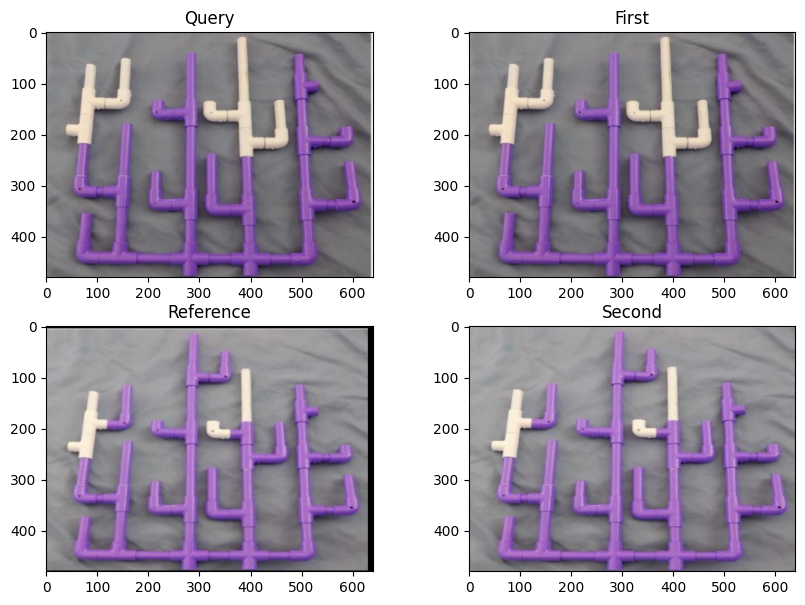

In [7]:
# Read images
nameOfSaveimg1 = "AfterFit1"  # Name for saving the first image after fitting
nameOfSaveimg2 = "AfterFit2"  # Name for saving the second image after fitting

# Load and resize the reference image
image1 = cv2.imread("reference.jpg")
image1 = cv2.resize(image1, (640, 480))

# Load and resize the input image
image2 = cv2.imread("image.jpg")
image2 = cv2.resize(image2, (640, 480))

# Flip the image to match the reference if required
if Flip == 1:
    image2 = cv2.flip(image2, 1)

# Fit the image to the reference
train, Query, trainMask2, QueryMask2 = resizing(image1, image2)

# Find the mask for the training image
_, _, _, trainMask = findArea(train)

# Find the mask for the query image
_, _, _, QueryMask = findArea(Query)

# Optionally save the HSV bounds
save_HSV = False
if save_HSV:
    np.savez("HSV.npz", lowerA=lowerA, upperA=upperA)

# Save the fitted images
cv2.imwrite(nameOfSaveimg1 + ".jpg", train)
cv2.imwrite(nameOfSaveimg2 + ".jpg", Query)

# Multi-show images in subplots
fig = plt.figure(figsize=(10, 7))
rows, columns = 2, 2

# Display the fitted training image
fig.add_subplot(rows, columns, 1)
plt.imshow(train)
plt.title("Query")

# Display the reference image
fig.add_subplot(rows, columns, 2)
plt.imshow(image1)
plt.title("First")

# Display the fitted query image
fig.add_subplot(rows, columns, 3)
plt.imshow(Query)
plt.title("Reference")

# Display the second input image
fig.add_subplot(rows, columns, 4)
plt.imshow(image2)
plt.title("Second")

# Show the images
plt.show()

# cv2.waitKey()  # Uncomment if you need to wait for a key press


# 2 - Image Initialization and Preprocessing

This section initializes the main image and prepares the training and query masks for further processing using OpenCV.

Using Thresholding and Morphological Operations to continuously monitors the values set by the trackbars to perform color thresholding on the green and saturation channels of the training and query masks. The results are displayed in separate windows, allowing for real-time adjustment of the thresholds.


In [8]:
# Initialize the main image and create a copy for further processing
main_img = image1  # Store the original image in 'main_img'

# Load the training and query masks into variables
stand_pic = trainMask  # Load the training mask into 'stand_pic'
live_pic = QueryMask  # Load the query mask into 'live_pic'

# Save the training and query masks as image files for reference
cv2.imwrite("Train.jpg", trainMask)  # Save trainMask as "Train.jpg"
cv2.imwrite("Query.jpg", QueryMask)  # Save QueryMask as "Query.jpg"

# Create copies of the images for further processing
stand_c = stand_pic.copy()  # Make a copy of the training mask for later use
live_c = live_pic.copy()  # Make a copy of the query mask for later use

# Smoothing images to reduce noise
## 1st smoother: Bilateral filter for edge-preserving smoothing
stand_pic = cv2.bilateralFilter(stand_pic, 9, 75, 75)  # Apply bilateral filter to the training mask
live_pic = cv2.bilateralFilter(live_pic, 9, 75, 75)  # Apply bilateral filter to the query mask

# 2nd smoother: Gaussian blur for additional smoothing
stand_pic = cv2.GaussianBlur(stand_pic, (5, 5), 1)  # Apply Gaussian blur to the training mask
live_pic = cv2.GaussianBlur(live_pic, (5, 5), 1)  # Apply Gaussian blur to the query mask

# Split the smoothed images into BGR channels
B_stand, G_stand, R_stand = cv2.split(stand_pic)  # Split the training mask into Blue, Green, and Red channels
B_live, G_live, R_live = cv2.split(live_pic)  # Split the query mask into Blue, Green, and Red channels

# Convert images from BGR to HSV color space
stand_pic = cv2.cvtColor(stand_pic, cv2.COLOR_BGR2HSV)  # Convert the training mask to HSV color space
live_pic = cv2.cvtColor(live_pic, cv2.COLOR_BGR2HSV)  # Convert the query mask to HSV color space

# Split the HSV images into their respective channels
H_stand, S_stand, V_stand = cv2.split(stand_pic)  # Split training mask into Hue, Saturation, and Value channels
H_live, S_live, V_live = cv2.split(live_pic)  # Split query mask into Hue, Saturation, and Value channels

# Create a window for color thresholding with trackbars
cv2.namedWindow('Color Track Bar')  # Create a window named 'Color Track Bar'

# Create trackbars to control the thresholds for Green and Saturation channels
cv2.createTrackbar("MaxG", "Color Track Bar", 0, 255, nothing)  # Trackbar for maximum green
cv2.createTrackbar("MinG", "Color Track Bar", 0, 255, nothing)  # Trackbar for minimum green
cv2.createTrackbar("MaxS", "Color Track Bar", 0, 255, nothing)  # Trackbar for maximum saturation
cv2.createTrackbar("MinS", "Color Track Bar", 0, 255, nothing)  # Trackbar for minimum saturation

# Set default values for the minimum thresholds of Green and Saturation
cv2.setTrackbarPos('MinG', 'Color Track Bar', 255)  # Set minimum green threshold to 255 (no green)
cv2.setTrackbarPos('MinS', 'Color Track Bar', 255)  # Set minimum saturation threshold to 255 (no saturation)

while (True):
    # Get the current positions of the trackbars for green and saturation thresholds
    green_low = cv2.getTrackbarPos("MaxG", "Color Track Bar")  # Get the maximum green threshold
    green_high = cv2.getTrackbarPos("MinG", "Color Track Bar")  # Get the minimum green threshold
    sat_low = cv2.getTrackbarPos("MaxS", "Color Track Bar")  # Get the maximum saturation threshold
    sat_high = cv2.getTrackbarPos("MinS", "Color Track Bar")  # Get the minimum saturation threshold

    # Apply thresholding to the green channels of both images
    ret, full_stand = cv2.threshold(G_stand, green_low, green_high, cv2.THRESH_BINARY_INV)  # Threshold for training mask's green channel
    ret, full_live = cv2.threshold(G_live, green_low, green_high, cv2.THRESH_BINARY_INV)  # Threshold for query mask's green channel

    # Thresholding for saturation channels
    ret, white_stand = cv2.threshold(G_stand, sat_low, sat_high, cv2.THRESH_BINARY_INV)  # Threshold for training mask's saturation channel
    ret, white_live = cv2.threshold(G_live, sat_low, sat_high, cv2.THRESH_BINARY_INV)  # Threshold for query mask's saturation channel

    # Perform morphological operations to refine the thresholds
    white_stand = dilation(white_stand, 2)  # Apply dilation to the whites image for training mask
    white_live = dilation(white_live, 2)  # Apply dilation again to further refine the query mask

    # Create pink images by subtracting the thresholds
    pink_stand = ~(cv2.subtract(white_stand, full_stand))  # Create a pink image for the training mask
    pink_live = ~(cv2.subtract(white_live, full_live))  # Create a pink image for the query mask

    # Erosion to refine the pink images
    pink_stand = errosion(pink_stand)  # Apply erosion to the pink image for the training mask
    pink_live = errosion(pink_live)  # Apply erosion to the pink image for the query mask

    # Display the results in separate windows
    cv2.imshow("full_stand", full_stand)  # Show thresholded green channel of the training mask
    cv2.imshow("full_live", full_live)  # Show thresholded green channel of the query mask
    cv2.imshow("white_stand", white_stand)  # Show thresholded saturation channel of the training mask
    cv2.imshow("white_live", white_live)  # Show thresholded saturation channel of the query mask
    # cv2.imshow("pink_stand", pink_stand)  # Show refined pink image for the training mask
    # cv2.imshow("pink_live", pink_live)  # Show refined pink image for the query mask

    # Check if the ESC key is pressed to exit the loop
    if cv2.waitKey(1) == 27: 
        # Save thresholded images before exiting
        Thresh_sat_stand = pink_stand.copy() 
        Thresh_sat_live = pink_live.copy()  
        Thresh_green_stand = white_stand.copy()
        Thresh_green_live = white_live.copy()
        break  

cv2.destroyAllWindows()  


## 3 - Image Processing for Growth, Damage, Bleaching, and Healing

This section applies Gaussian blur for smoothing, calculates growth, damage, and bleaching layers using image subtraction, and finds contours in the processed images.

In [9]:
# Apply additional Gaussian blur to the thresholded images for further smoothing
Thresh_sat_stand = cv2.GaussianBlur(Thresh_sat_stand, (5, 5), 1)  # Blur the first thresholded saturation image
Thresh_sat_live = cv2.GaussianBlur(Thresh_sat_live, (5, 5), 1)  # Blur the second thresholded saturation image
Thresh_green_stand = cv2.GaussianBlur(Thresh_green_stand, (5, 5), 1)  # Blur the first thresholded green image
Thresh_green_live = cv2.GaussianBlur(Thresh_green_live, (5, 5), 1)  # (Corrected) Blur the second thresholded green image

# Calculate growth layers using image subtraction
growth_2     = cv2.subtract(full_stand, full_live)  # Calculate growth by subtracting thresholded full_stand from full_live
growth_3     = cv2.subtract(growth_2, white_stand)  # Further refine growth by subtracting the thresholded whites
growth_4     = cv2.subtract(growth_3, white_live)  # Final growth calculation by subtracting the thresholded whites

# Display growth_4 image if the flag 'seeToEdit' is True
if seeToEdit:
    cv2.imshow("wishes", growth_4)  # Show the processed growth image

# Calculate damage layers using image subtraction
damage_2 = cv2.subtract(full_live, full_stand)  # Calculate damage by subtracting full_stand from full_live
damage_2 = cv2.subtract(damage_2, pink_stand)  # Refine damage by subtracting pinks

# Calculate bleaching layers using image subtraction
bleach_0 = cv2.subtract(white_live, white_stand)  # Calculate bleach effect by subtracting whites from white_stand

# Display bleach_0 image if the flag 'seeToEdit' is True
if seeToEdit:
    cv2.imshow("secondwish", bleach_0)  # Show the processed bleaching image

# Calculate cured layers using image subtraction
cured_0     = cv2.subtract(white_stand, white_live)  # Calculate cured effect by subtracting white_live from white_stand
cured_0     = cv2.subtract(cured_0, damage_2)  # Further refine cured effect by subtracting damage_2

# Display various processed images if the flag 'seeToEdit' is True
if seeToEdit:
    cv2.imshow("growth_2", growth_2)  # Show the growth_2 image
    cv2.imshow("damage_2", damage_2)  # Show the damage_2 image
    cv2.imshow("cured_0", cured_0)  # Show the cured_0 image

# Noise Removal: Apply median blur to smooth out the images further
growth_2 = cv2.medianBlur(growth_2, 13)  # Apply median blur to the growth_2 image
damage_2 = cv2.medianBlur(damage_2, 13)  # Apply median blur to the damage_2 image
bleach_2 = cv2.medianBlur(bleach_0, 13)  # Apply median blur to the bleach_0 image
cured_2  = cv2.medianBlur(cured_0, 13)  # Apply median blur to the cured_0 image

# Find contours in the processed images
Pinkgrow, hierarchy = cv2.findContours(growth_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the growth_2 image
Pinkdamage, hierarchy = cv2.findContours(damage_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the damage_2 image
bleached, hierarchy = cv2.findContours(bleach_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the bleached image
Pinkheal, hierarchy = cv2.findContours(cured_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the cured_2 image


## 4 - Image Contour Processing for Bleach, Growth, Healing, and Damage - Final Results

This section processes contours for various conditions—bleach, growth, healing, and damage—using OpenCV.

In [ ]:
bleach = []  # List to store bleach areas
damage = []  # List to store damage areas
heal = []    # List to store healing areas
growth = []  # List to store growth areas

minArea = 1000  # Minimum contour area to consider
maxArea = 50000  # Maximum contour area to consider

# Process bleached contours
for cnt in bleached: # Red
    if maxArea > cv2.contourArea(cnt) > minArea:  # Check if the contour area is within limits
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  # Approximate the contour
        M_W = cv2.moments(approx)  # Get moments of the contour
        x, y, w, h = cv2.boundingRect(cnt)  # Get bounding rectangle of the contour
        cv2.drawContours(main_img, cnt, -1, (0, 0, 255), 3)  # Draw the contour in red on main_img
        cv2.rectangle(live_c, (x - 10, y - 10), (x + w + 10, y + h + 10), (0, 0, 255), 2)  # Draw rectangle around the contour
        b = [x, y, h, w]  # Store contour information
        bleach.append(b)  # Append to the bleach list
        if seeToEdit:
            print("here is bleach ", bleach)  # Print bleach areas if editing is enabled

# Process growth contours
for cnt in Pinkgrow:  # Green
    if maxArea > cv2.contourArea(cnt) > minArea:  # Check area limits
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  # Approximate the contour
        M_P = cv2.moments(approx)  # Get moments of the contour
        x, y, w, h = cv2.boundingRect(cnt)  # Get bounding rectangle
        cv2.rectangle(live_c, (x - 10, y - 10), (x + w + 10, y + h + 10), (0, 255, 0), 2)  # Draw rectangle around growth
        cv2.drawContours(main_img, cnt, -1, (0, 255, 0), 3)  # Draw contour in green
        g = [x, y, h, w]  # Store contour information
        growth.append(g)  # Append to the growth list
        if seeToEdit:
            print("here is growth ", growth)  # Print growth areas if editing is enabled

# Process healing contours
for cnt in Pinkheal: # Blue
    if maxArea > cv2.contourArea(cnt) > minArea:  # Check area limits
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  # Approximate the contour
        M_P = cv2.moments(approx)  # Get moments
        x, y, w, h = cv2.boundingRect(cnt)  # Get bounding rectangle
        cv2.rectangle(live_c, (x - 10, y - 10), (x + w + 10, y + h + 10), (255, 0, 0), 2)  # Draw rectangle for healing
        cv2.drawContours(main_img, cnt, -1, (255, 0, 0), 3)  # Draw contour in blue
        h = [x, y, h, w]  # Store contour information
        heal.append(h)  # Append to the heal list
        if seeToEdit:
            print("done3")
            print("here is heal ", heal)  # Print heal areas if editing is enabled

# Process damage contours
for cnt in Pinkdamage: # yellow
    if maxArea > cv2.contourArea(cnt) > minArea:  # Check area limits
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  # Approximate the contour
        M_P = cv2.moments(approx)  # Get moments
        # Calculate x, y coordinate of center
        if M_P["m00"] == 0:  # Prevent division by zero
            M_P["m00"] = 1
        cX = int(M_P["m10"] / M_P["m00"])  # Center x-coordinate
        cY = int(M_P["m01"] / M_P["m00"])  # Center y-coordinate
        x, y, w, h = cv2.boundingRect(cnt)  # Get bounding rectangle
        cv2.drawContours(live_c, cnt, -1, (255, 255, 0), 3)  # Draw contour in yellow
        cv2.rectangle(main_img, (x - 10, y - 10), (x + w + 10, y + h + 10), (255, 255, 0), 2)  # Draw rectangle for damage
        d = [x, y, h, w]  # Store contour information
        damage.append(d)  # Append to the damage list
        if seeToEdit:
            print("here is damage ", damage)  # Print damage areas if editing is enabled

# Display results
cv2.imshow("IMG2", live_c)  # Show processed live image
cv2.imshow("img", stand_c)  # Show processed standing image
cv2.imshow("main", main_img)  # Show main image with contours

# Save results to files
cv2.imwrite('Result1.jpg', main_img)  # Save the main image with contours
cv2.imwrite('Result2.jpg', live_c)  # Save the processed live image
cv2.waitKey(0)  # Wait for a key press
cv2.destroyAllWindows()  

here is bleach  [[381, 180, 61, 48]]
here is bleach  [[381, 180, 61, 48], [430, 139, 82, 41]]
here is bleach  [[381, 180, 61, 48], [430, 139, 82, 41], [312, 139, 36, 73]]
here is bleach  [[381, 180, 61, 48], [430, 139, 82, 41], [312, 139, 36, 73], [42, 68, 145, 52]]
here is bleach  [[381, 180, 61, 48], [430, 139, 82, 41], [312, 139, 36, 73], [42, 68, 145, 52], [99, 56, 89, 64]]
here is growth  [[42, 155, 103, 77]]
done3
here is heal  [[46, 151, 104, 68]]
